In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
from math import isnan

# Visualization plots
from matplotlib import pyplot as plt
import seaborn as sns

# ML Data Preparation
from sklearn.preprocessing import LabelEncoder # labeling of categorical target variables
from sklearn.preprocessing import StandardScaler # scale values to standard normal distribution X~N(0,1)
from sklearn.model_selection import train_test_split # train-test data split

# ML Feature Importance Analysis
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# ML Techniques
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ML Model Evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# Support Vector Machine
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

In [2]:
# Set parameters
RAND_STATE_SEED = 16
TEST_SIZE = 0.2

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train[df_train['compliance_2021']==1]['compliance_2021'].count()/df_train['station_id'].count()

0.15

## 1. Data Exploration

### 1.1 Overview

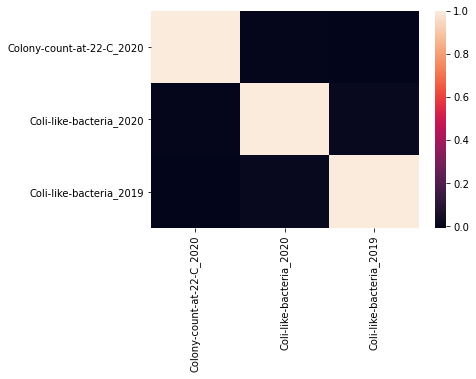

In [5]:
# select = ['Colony-count-at-22-C_2020','Coli-like-bacteria_2020','Colony-count-at-22-C_2020'] #good combi
select = ['Colony-count-at-22-C_2020','Coli-like-bacteria_2020','Coli-like-bacteria_2019'] 
# select = ['Colony-count-at-22-C_2020','Electrical-conductivity_2019']
sns.heatmap(df_train[select].corr())

In [6]:
con_filter = ~df_train['Coli-like-bacteria_2020'].isna() & ~df_train['Enterococci_2020'].isna()
df_train[['station_id','Coli-like-bacteria_2020','Enterococci_2020']][con_filter]

,station_id,Coli-like-bacteria_2020,Enterococci_2020
2,205,0.0,0.0
11,1417,0.0,0.0
12,169,0.0,0.0
43,1074,0.0,0.0
46,444,0.0,0.0
...,...,...,...
416,172,2.0,0.0
417,769,4.0,0.0
418,382,0.0,0.0
421,566,0.0,0.0


### 1.2 Data Analysis

The features Manganese_2019, Coli-like-bacteria_2020, Coli-like-bacteria-Colilert_2020, Coli-like-bacteria_2019 and
compliance_2020 demonstrate the largest %change for a 0-1 compliance_2021 split.

These mentioned features could have importance in model building.

In [7]:
# To screen columns by year
# df_ex = df_train.loc[:,~df_train.columns.str.match(r'(.*?)\_2019')].groupby(['compliance_2021']).mean().T
# df_ex['% diff'] = abs(df_ex[1]-df_ex[0])*100/df_train.loc[:,~df_train.columns.str.match(r'(.*?)\_2019')].mean().T

df_ex = df_train.groupby(['compliance_2021']).mean().T
df_ex['% abs diff'] = abs(df_ex[1]-df_ex[0])*100/df_train.mean().T

df_ex.sort_values(by = '% abs diff',ascending = False).head(10)

compliance_2021,0,1,% abs diff
Manganese_2019,28.605680,204.417021,286.962630
Coli-like-bacteria_2020,0.300353,1.432432,262.511090
Coli-like-bacteria-Colilert_2020,0.868750,2.758621,144.573951
Coli-like-bacteria_2019,1.118705,3.045455,139.418729
compliance_2020,0.160428,0.424242,131.907308
Escherichia-coli-Colilert_2020,0.021053,0.000000,130.526316
Colony-count-at-22-C_2020,30.975904,80.490909,130.258359
Enterococci_2020,0.022059,0.000000,127.205882
Escherichia-coli-Colilert_2019,0.522449,0.000000,126.530612
Smell-ball-units_2019,0.367816,0.875000,123.544798


In [8]:
# Count of NaN in the original dataset
pd.DataFrame(df_train.isna().sum(),columns=['Count of NaN']).sort_values(by = 'Count of NaN',ascending = False).head()

,Count of NaN
Color-Pt-Co-unit_2019,381
Color-Pt-Co-unit_2020,377
Aluminium_2020,346
Taste-ball-units_2019,346
Smell-ball-units_2019,345


## 2. Data Preprocessing

In [9]:
y = df_train['compliance_2021'] # Target variable
df_train = df_train.drop('compliance_2021',axis=1)

In [10]:
X = df_train.drop(['station_id'],axis=1)
station_id = df_train['station_id']

### 2.1 Transform the dataset

* Group related features and pair the readings into a list, for example [NaN,NaN]
* Remove the duplicated feature
* Remove the suffix _YYYY from the name of each feature

In [11]:
col_names = X.columns # store original column names

In [12]:
grouped = X.groupby(lambda col: col[:-5], axis=1) # remove all '_2019' and '_2020' suffixes

X = grouped.transform(lambda x: x.values.tolist())
X = X.loc[:,~X.columns.str.match(r'(.*?)\_2020')]
X = X.rename(columns=lambda x: re.sub(r'\_2019', '', x))

### 2.2 Manual Data Impute

* Impute NaN with value from either the trailing (2019) or forward year (2020). 
* If both values are NaN, leave it.
* Implement method as a function

In [13]:
def replace_nan(x):
    if len(x)==2 and isinstance(x, list) and isnan(x[0])+isnan(x[1])==1:
        nn_0 = 0 if isnan(x[0]) else x[0]
        nn_1 = 0 if isnan(x[1]) else x[1]
        x[0] = nn_0 + nn_1
        x[1] = nn_0 + nn_1
    return x

X = X.applymap(replace_nan)

In [14]:
X = pd.concat([X.iloc[:,i].apply(pd.Series) for i in range(X.shape[1])],axis=1)
X.columns = col_names

In [15]:
# Count of NaN after first round of manual data impute
pd.DataFrame(X.isna().sum(),columns=['Count of NaN']).sort_values(by = 'Count of NaN',ascending = False).head()

,Count of NaN
Color-Pt-Co-unit_2019,371
Color-Pt-Co-unit_2020,371
Taste-ball-units_2019,332
Taste-ball-units_2020,332
Smell-ball-units_2020,330


In [16]:
df_m = pd.concat([X.loc[:,X.columns != 'station_id'],y],axis=1).groupby(['compliance_2021']).mean().T
df_m['abs diff'] = abs(df_m[1]-df_m[0])

df_m.sort_values(by = 'abs diff',ascending = False).head(10)

compliance_2021,0,1,abs diff
Manganese_2019,39.026492,172.312069,133.285577
Iron_2020,104.872694,163.384127,58.511433
Iron_2019,131.005931,187.400159,56.394228
Colony-count-at-22-C_2020,30.507082,79.967213,49.460131
Manganese_2020,32.345565,68.631034,36.285470
Chloride_2020,51.160584,81.762162,30.601578
Electrical-conductivity_2019,548.506417,578.030303,29.523886
Colony-count-at-22-C_2019,34.101983,60.442623,26.340640
Chloride_2019,55.806569,77.808108,22.001539
Coli-like-bacteria-Colilert_2019,22.714545,2.848485,19.866061


### 2.3 Standard Scaling and impute Missing Values with 0

In [17]:
scale= StandardScaler()
# standardization of dependent variables
X.iloc[:,:-2] = scale.fit_transform(X.iloc[:,:-2])

In [18]:
X = X.fillna(0) #fill missing readings with 0 , after standard scaling is equivalent to filling with avg value

### 2.4 Feature Engineering

In [19]:
X_fe = X.iloc[:,:-2]
grouped = X_fe.groupby(lambda col: col[:-5], axis=1) # remove all '_2019' and '_2020' suffixes

X_fe = grouped.transform(lambda x: x.values.tolist())
X_fe = X_fe.loc[:,~X_fe.columns.str.match(r'(.*?)\_2020')]
X_fe = X_fe.rename(columns=lambda x: re.sub(r'\_2019', '', x))

In [20]:
# Another feature engineering option - to find yoy change of measurement
def find_chng_yoy(x):
    if isinstance(x, list):
        try:
            return x[1] - x[0]
        except:
            return 0
        
# X_fe1 = X_fe.applymap(np.mean)
X_fe1 = X_fe.applymap(find_chng_yoy)
X = pd.concat([X_fe1,X.iloc[:,-2:]],axis=1)

In [21]:
# X_fe2 = X_fe.applymap(find_pct_chng_yoy)
# X_fe2.columns = X.columns[:-2] + ['_chng']*X_fe2.shape[1]
# X = pd.concat([X_fe2,X],axis=1)

In [22]:
# create dummy variables
X = pd.get_dummies(X, columns = ['compliance_2019','compliance_2020'])

In [25]:
df_m = pd.concat([X.loc[:,X.columns != 'station_id'],y],axis=1).groupby(['compliance_2021']).mean().T
df_m['abs diff'] = abs(df_m[1]-df_m[0])

df_m.sort_values(by = 'abs diff',ascending = False).head(30)

compliance_2021,0,1,abs diff
Colony-count-at-22-C,-0.044270,0.250861,0.295131
compliance_2020_1,0.160428,0.424242,0.263815
compliance_2020_0,0.839572,0.575758,0.263815
Coli-like-bacteria-Colilert,-0.037606,0.213103,0.250709
Taste-dilution-degree,-0.032015,0.181421,0.213436
compliance_2019_1,0.165775,0.378788,0.213012
compliance_2019_0,0.834225,0.621212,0.213012
Ammonium,-0.027252,0.154427,0.181679
Odour-dilution-level,-0.017456,0.098915,0.116370
pH,-0.016027,0.090818,0.106845


### 2.5 Box plot and ANOVA

In [ ]:
X.describe().T

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 4), sharex=True, sharey=False)
    
for i in range(2):
    for j in range(2):
        axs[i,j].boxplot(X.iloc[:,i*2+j],
                    vert=True,  # vertical box alignment
                    patch_artist=True)  # will be used to label x-ticks
        axs[i,j].yaxis.grid(True)
        axs[i,j].set_title(X.columns[i*2+j])

for ax in axs.flat:
    ax.set(xlabel= 'feature', ylabel= 'Value')

plt.show()

## 3. Analysis - Feature Selection

### Feature Selection Combination 1 - Gradient Boosting Classifier

In [ ]:
# # Feature bucket 1 - Inorganic components
selectB1 = ['Aluminium','Ammonium','Boron','Chloride','Fluoride','Iron','Manganese',
           'Nitrate','Nitrite','Sodium','Sulphate']
# selectB1 = ['Aluminium','Ammonium','Boron','Iron','Manganese',
#            'Nitrate','Nitrite','Sodium','Sulphate']
# # Feature bucket 2 - Microbe components
# selectB2 = ['Coli-like-bacteria-Colilert','Coli-like-bacteria','Colony-count-at-22-C']

# # Feature bucket 3 - Qualitative Analysis - Instrument measurements
# selectB3 = ['Color-Pt-Co-unit','Color-Pt/Co-scale','Electrical-conductivity','Odour-dilution-level',
#           'Oxidability','Smell-ball-units','Taste-ball-units','Taste-dilution-degree','Turbidity-NTU',
#           'pH ']

select1 = selectB1
# select1 = list(X.columns[1:-3]) # select all features for GB model

In [ ]:
sns.heatmap(X[select1].corr())

### Feature Selection Combination 2 - Logistic Regression

In [ ]:
# select2 = ['Coli-like-bacteria_2020','Colony-count-at-22-C_2020'] #good combi
# select2 = ['Colony-count-at-22-C_2020','Coli-like-bacteria_2020','Coli-like-bacteria_2019'] 
select2 = ['Manganese','Coli-like-bacteria','Colony-count-at-22-C'] 
# select2 = ['Colony-count-at-22-C_2020','Electrical-conductivity_2019']
sns.heatmap(X[select2].corr())

In [ ]:
gbc_select = select1 # Change feature selection for GB classifier here
svm_select = select1 # Change feature selection for SVM classifier here
lr_select = select2 # Change feature selection for logistic regression here

### 3.1 Feature Selection

The output of this sub-section only serves as an insight, but is not used in the decision making process of feature selection.

### a. Display Feature importance (Tree-based) - Not implemented

In [ ]:
col_names = X.columns

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_ 
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

In [ ]:
feature = pd.DataFrame([col_names,clf.feature_importances_],index=['feature', 'impt_score'])
feature = feature.T.sort_values(by = ['impt_score'], ascending=False)
feature.head(10)

### b. L1-based feature selection - (Not implemented)

In [ ]:
model = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
                                        , prefit=True))
])

X_new = model.transform(X)

In [ ]:
fs = pd.DataFrame(X_new).sum(axis=0)
fa = pd.DataFrame(X.sum(),columns = ['sum'])
fa['match'] = fa['sum'].isin(fs)

In [ ]:
fa[fa['match']].index # Selected features 

In [ ]:
X_new.shape

In [ ]:
X_lr = X_new
pd.DataFrame(X,columns=fa[fa['match']].index)

## 4. Model Development - Logistic Regression

In [ ]:
X_lr = X.loc[:,lr_select]

In [ ]:
X_lr = pd.DataFrame(X_lr, columns=lr_select)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_lr,y,test_size = TEST_SIZE, 
                                                 random_state = RAND_STATE_SEED, stratify=y)
le = LabelEncoder() # encoder to do label encoder
y_train = le.fit_transform(y_train) #apply LE to all columns
y_test = le.fit_transform(y_test) #apply LE to all columns

### 4.1 Logistic Regression Model

In [ ]:
print(X_lr.shape)
y_test

In [ ]:
# Grid Search Parameter
param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': [0.7, 0.3]                                   
}

logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=RAND_STATE_SEED), 
                             param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)

In [ ]:
# Grid Search to find the best estimator
logModel_grid.fit(X_train, y_train)
print(logModel_grid.best_estimator_)

In [ ]:
lr = LogisticRegression(C=1.0, class_weight=[0.7, 0.3], dual=False, 
                        fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=20, 
                        multi_class='ovr', n_jobs=None, penalty='l2', random_state=RAND_STATE_SEED, 
                        solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

model = lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [ ]:
print("Kaggle equivalent accuracy score on validation dataset is %.4g" % model.score(X_test, y_test))

In [ ]:
y_pred

### 4.2 Model Evaluation - Logistic Regression

In [ ]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Sensitivity Recall: %.3f' % metrics.recall_score(y_test, y_pred))

In [ ]:
# Cross-validation procedure used to compare the performance of machine learning models.

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RAND_STATE_SEED)
# evaluate model
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
# report performance
print('K-Fold Cross Validation Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('K-Fold Cross Validation Precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))

In [ ]:
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    fpr,
    tpr,
    color="grey",
    lw=2,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")
plt.show()

In [ ]:
y_pred

In [ ]:
print(lr.coef_)
print(lr.intercept_)

## 5. Model Development - Support Vector Machines

In [ ]:
X_svm = X.loc[:,svm_select]
scale= StandardScaler()
# standardization of dependent variables
X_svm = scale.fit_transform(X_svm)
X_svm = pd.DataFrame(X_svm, columns = svm_select)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_svm,y,test_size= TEST_SIZE,random_state = RAND_STATE_SEED, stratify=y)

In [ ]:
# Grid Search Parameter
param_grid_svm = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': [0.7, 0.3]                                   
}

svmModel_grid = GridSearchCV(estimator=SVC(random_state=RAND_STATE_SEED), 
                             param_grid=param_grid_svm, verbose=1, cv=10, n_jobs=-1)
svmModel_grid  # need to rewrite code for this cell

In [ ]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

svm_model = polynomial_svm_clf.fit(X_train,y_train)

In [ ]:
svm_model.score(X_test, y_test)
print("Kaggle equivalent accuracy score on validation dataset is %.4g" % svm_model.score(X_test, y_test))

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

### 5.1 Model Evaluation - Support Vector Machine 

In [ ]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Sensitivity Recall: %.3f' % metrics.recall_score(y_test, y_pred))

In [ ]:
# Cross-validation procedure used to compare the performance of machine learning models.

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RAND_STATE_SEED)
# evaluate model
accuracy = cross_val_score(svm_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
precision = cross_val_score(svm_model, X, y, scoring='precision', cv=cv, n_jobs=-1)
# report performance
print('K-Fold Cross Validation Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('K-Fold Cross Validation Precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))

In [ ]:
y_pred_proba = svm_model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    fpr,
    tpr,
    color="grey",
    lw=2,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")
plt.show()

## 6. Model Development - Gradient Boost Classifier

In [ ]:
# gbc_select = ['Aluminium_2019', 'Aluminium_2020', 'Ammonium_2019',
#        'Ammonium_2020', 'Boron_2019', 'Boron_2020', 'Chloride_2019',
#        'Chloride_2020', 'Coli-like-bacteria-Colilert_2019',
#        'Coli-like-bacteria-Colilert_2020', 'Coli-like-bacteria_2019',
#        'Coli-like-bacteria_2020', 'Colony-count-at-22-C_2019',
#        'Colony-count-at-22-C_2020', 'Fluoride_2019',
#        'Fluoride_2020', 'Iron_2019', 'Iron_2020', 'Manganese_2019',
#        'Manganese_2020', 'Nitrate_2019', 'Nitrate_2020', 'Nitrite_2019',
#        'Nitrite_2020', 'Oxidability_2019', 'Oxidability_2020', 'Sodium_2019',
#        'Sodium_2020', 'Sulphate_2019', 'Sulphate_2020']

# gbc_select = X.iloc[:,1:-4].columns
X_gbc = X.loc[:,gbc_select]
scale= StandardScaler()
# standardization of dependent variables
X_gbc = scale.fit_transform(X_gbc)
X_gbc = pd.DataFrame(X_gbc, columns = gbc_select)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_gbc,y,test_size= TEST_SIZE,random_state = RAND_STATE_SEED, stratify=y)

In [ ]:
# learning_rates = [1, 0.5, 0.1, 0.01]
learning_rates = [0.5]


for eta in learning_rates:
    gbclf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                               learning_rate=eta, loss='deviance', max_depth=3,
                               max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                               n_estimators=500, presort='auto', random_state=RAND_STATE_SEED,
                               subsample=1.0, verbose=0, warm_start=False)
    gb_model = gbclf.fit(X_train, y_train)

In [ ]:
gbclf.score(X_test, y_test)
print("Kaggle equivalent accuracy score on validation dataset is %.4g" % gbclf.score(X_test, y_test))

In [ ]:
y_pred = gbclf.predict(X_test)

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

### 6.1 Model Evaluation - Gradient Boost Classifier

In [ ]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, predictors)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, predictors, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(predictors.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(predictors, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),min(cv_score),max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15, 5))
        plt.ylabel('Feature Importance Score')


In [ ]:
modelfit(gbclf, X_train, y_train)

In [ ]:
# Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
print('Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Sensitivity Recall: %.3f' % metrics.recall_score(y_test, y_pred))

In [ ]:
# Cross-validation procedure used to compare the performance of machine learning models.

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RAND_STATE_SEED)
# evaluate model
accuracy = cross_val_score(gb_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
precision = cross_val_score(gb_model, X, y, scoring='precision', cv=cv, n_jobs=-1)
# report performance
print('K-Fold Cross Validation Accuracy: %.3f (%.3f)' % (np.mean(accuracy), np.std(accuracy)))
print('K-Fold Cross Validation Precision: %.3f (%.3f)' % (np.mean(precision), np.std(precision)))

In [ ]:
y_pred_proba = gbclf.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    fpr,
    tpr,
    color="grey",
    lw=2,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")
plt.show()

## a. Submission with Logistic Regression

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_test.shape

In [ ]:
df_test.describe().T.head()

In [ ]:
col_names = df_test.columns # store original column names
grouped = df_test.groupby(lambda col: col[:-5], axis=1) # remove all '_2019' and '_2020' suffixes

X = grouped.transform(lambda x: x.values.tolist())
X = X.loc[:,~X.columns.str.match(r'(.*?)\_2020')]
X = X.rename(columns=lambda x: re.sub(r'\_2019', '', x))

In [ ]:
X = X.applymap(replace_nan)

In [ ]:
X = pd.concat([X.iloc[:,i].apply(pd.Series) for i in range(X.shape[1])],axis=1)
X.columns = col_names

### a.1 Standard scaling

In [ ]:
scale = StandardScaler()

# standardization of dependent variables
X = scale.fit_transform(X)
X = pd.DataFrame(X,columns = col_names) 

### a.2 Feature engineering option

In [ ]:
X_fe = X.iloc[:,:-2]
grouped = X_fe.groupby(lambda col: col[:-5], axis=1) # remove all '_2019' and '_2020' suffixes

X_fe = grouped.transform(lambda x: x.values.tolist())
X_fe = X_fe.loc[:,~X_fe.columns.str.match(r'(.*?)\_2020')]
X_fe = X_fe.rename(columns=lambda x: re.sub(r'\_2019', '', x))
        
X_fe = X_fe.applymap(np.mean)
X = pd.concat([X_fe,X.iloc[:,-2:]],axis=1)

In [ ]:
X = pd.get_dummies(X, columns = ['compliance_2019','compliance_2020']) # create dummy variables

In [ ]:
X_lr = X.loc[:,lr_select]

In [ ]:
X_lr = X_lr.fillna(0)

In [ ]:
pred = lr.predict(X_lr)
pred

In [ ]:
result = pd.DataFrame({"station_id":df_test["station_id"], "compliance_2021":pred})

In [ ]:
result.groupby(['compliance_2021']).count()

In [ ]:
result.to_csv("lg_submission.csv", index=False)

## b. Submission with Gradient Boosting

In [ ]:
X_gbc = X[gbc_select]
X_gbc = X_gbc.fillna(0)

In [ ]:
X_gbc

In [ ]:
pred = gbclf.predict(X_gbc)
pred

In [ ]:
result = pd.DataFrame({"station_id":df_test["station_id"], "compliance_2021":pred})

In [ ]:
result.groupby(['compliance_2021']).count()

In [ ]:
result.to_csv("gbclf_submission.csv", index=False) # Accuracy = 0.8404

## c. Submission with Support Vector Classification

In [ ]:
X_svc = X[svm_select]
X_svc = X_svc.fillna(0)

In [ ]:
X_svc

In [ ]:
pred = svm_model.predict(X_svc)
pred

In [ ]:
result = pd.DataFrame({"station_id":df_test["station_id"], "compliance_2021":pred})

In [ ]:
result.groupby(['compliance_2021']).count()

In [ ]:
result.to_csv("svclf_submission.csv", index=False) # Accuracy = ?